# Single-Atom Local Gaussian Fit
This minimal notebook builds a single-atom projected potential, places one Gaussian beam at the centre, and compares the Gaussian phase with the local potential curvature. We also show a 1D phase cross-section.

In [1]:
# Imports and config
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from ase import Atoms
import abtem
from abtem.core.energy import energy2wavelength, energy2sigma

from temgym_core.utils import fibonacci_spiral
from temgym_core.components import Detector
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import Potential, FreeSpaceParaxial, evaluate_gaussian_packets_jax_scan, run_to_end

jax.config.update('jax_enable_x64', True)
%matplotlib widget

In [2]:
# Build a single-atom projected potential and a Gaussian at the centre

def make_single_atom(symbol='Si', box_A=(20.0, 20.0, 20.0)):
    Lx, Ly, Lz = map(float, box_A)
    return Atoms(
        symbols=symbol,
        positions=[[Lx / 2, Ly / 2, Lz / 2]],
        cell=[Lx, Ly, Lz],
        pbc=False
    )

def projected_potential_2d(
    src,
    sampling_A=0.02,
    parametrization='lobato',
    projection='infinite',
    periodic=False,
    box_A=None,
    slice_thickness=1.0
):
    # Use abTEM to compute projected potential and return V2d with sampling/origin matching temgym Potential
    if isinstance(src, Atoms):
        pot = abtem.Potential(
            src,
            sampling=sampling_A,
            parametrization=parametrization,
            projection=projection,
            periodic=periodic,
            slice_thickness=slice_thickness,
            box=None if box_A is None else tuple(map(float, box_A))
        )
        proj = pot.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    elif hasattr(src, 'project') and hasattr(src, 'compute'):
        proj = src.project().compute()
        V2d = np.asarray(proj.array)
        sy, sx = proj.sampling
    else:
        raise TypeError('Unsupported src for projected_potential_2d')
    ny, nx = V2d.shape
    Lx, Ly = nx * sx, ny * sy
    x0, y0 = -Lx / 2.0, -Ly / 2.0
    return V2d, float(sx), float(sy), float(x0), float(y0)

In [3]:

# Parameters
accel_V = 200_000
wavelength = energy2wavelength(accel_V)
sigma = energy2sigma(accel_V)

# Single atom
Lx, Ly, Lz = 2.0, 2.0, 2.0
atoms = make_single_atom('Si', box_A=(Lx, Ly, Lz))
V2d, sx, sy, x0, y0 = projected_potential_2d(atoms, sampling_A=0.001, parametrization='lobato', projection='infinite', periodic=False, box_A=(Lx, Ly, Lz))

# Wrap as a thin potential component
comp = Potential(z=0.0, V=jnp.asarray(V2d, dtype=jnp.float64), sx=sx, sy=sy, x0=x0, y0=y0, sigma=float(sigma), order=3)

# Build a small detector/grid for field evaluation
W = Lx  # window size in Å
Nx, Ny = V2d.shape[1], V2d.shape[0]
dx = W / Nx
dy = W / Ny
grid = Detector(z=0.0, pixel_size=(dy, dx), shape=(Ny, Nx))

extent = (x0, x0 + Nx * dx, y0, y0 + Ny * dy)

# Single Gaussian centred at origin
w0 = 0.01  # beam waist parameter (Å)
print(wavelength)
num_rays = 1
rx, ry = fibonacci_spiral(num_rays, radius=0.5)
rx = rx + 0.1
lam = jnp.ones(num_rays) * wavelength
k0 = 2 * jnp.pi / lam
C0 = jnp.ones(num_rays) * (1.0 + 0.0j)
eta = jnp.zeros((num_rays, 2), dtype=jnp.complex128)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)
ray0 = GaussianRayBeta(x=rx, y=ry, dx=jnp.zeros_like(rx), dy=jnp.zeros_like(ry), z=jnp.zeros_like(rx), pathlength=jnp.zeros_like(rx), Q_inv=Qinv0, eta=eta, C=C0, k0=k0)
ray0 = ray0.to_vector()
components = [comp]
ray_out = run_to_end(ray0, components)
E_input = evaluate_gaussian_packets_jax_scan(ray0, grid, batch_size=64)
E_gauss = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=64)
E_sample = np.exp(1j * np.asarray(V2d) * float(sigma) * k0[0]) * np.asarray(E_input).reshape(Ny, Nx)


[########################################] | 100% Completed | 2.88 ss
[########################################] | 100% Completed | 2.88 s
0.025079340317328468
0.025079340317328468


/home/dl277493/Microscope-Calibration/TemGymCore/src/temgym_core/utils.py:310: RuntimeWarning: invalid value encountered in sqrt
  radius * np.sqrt((ii + 0.5) / (nb_samples - 0.5 * (np_boundary + 1)))


(-1.09945, 1.09945, -0.0645291538298102, 2.039416661827528)

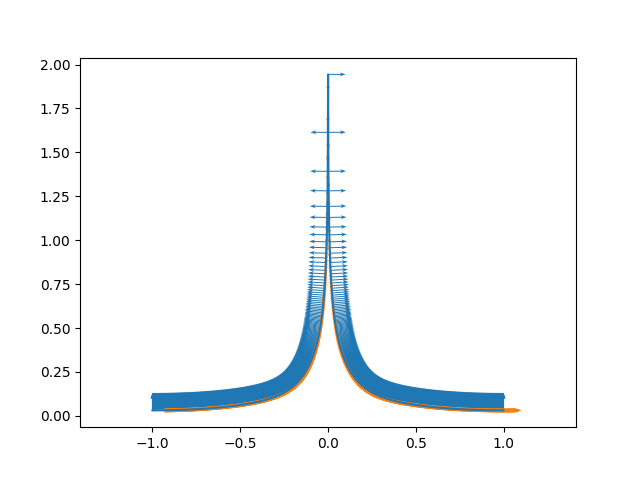

In [4]:
x, y = grid.coords_1d
xy = jnp.stack([x, jnp.zeros_like(x)], axis=-1)

V_comp = sigma * comp.V
V_cross_section = V_comp[V_comp.shape[0] // 2, :]
dV_comp = sigma * comp.grad_V(xy)
dV_comp = dV_comp[:, 0]
shape = comp.V.shape
fig, ax = plt.subplots()
ax.plot(x, V_cross_section, '-', label='V')

# slope at sampled points
m_s = dV_comp

# fixed arrow length in x
arrow_len_x = (x[-1] - x[0]) * 0.05

# normalization factor
norm_t = jnp.sqrt(1 + m_s**2)

# tangent vectors (unit tangent scaled to arrow_len_x in x)
tx = arrow_len_x / norm_t
ty = m_s * arrow_len_x / norm_t

# normal vectors (perpendicular to tangent, same scaling)
nx = -m_s * arrow_len_x / norm_t
ny = arrow_len_x / norm_t

ax.quiver(x, V_cross_section, nx, ny,
          angles='xy', scale_units='xy', scale=1,
          color='C0', width=0.002, headwidth=4, headlength=6,
          label='normal')

ax.quiver(x, V_cross_section, tx, ty,
          angles='xy', scale_units='xy', scale=1,
          color='C1', width=0.002, headwidth=4, headlength=6,
          label='tangent')

plt.axis('equal')

In [5]:
opl_from_ray = ray_out.C
opl_from_component = comp.complex_action(jnp.array([rx, ry]).T)
print(jnp.angle(opl_from_ray), opl_from_component)

[0.30592694] [0.30592694+0.j]


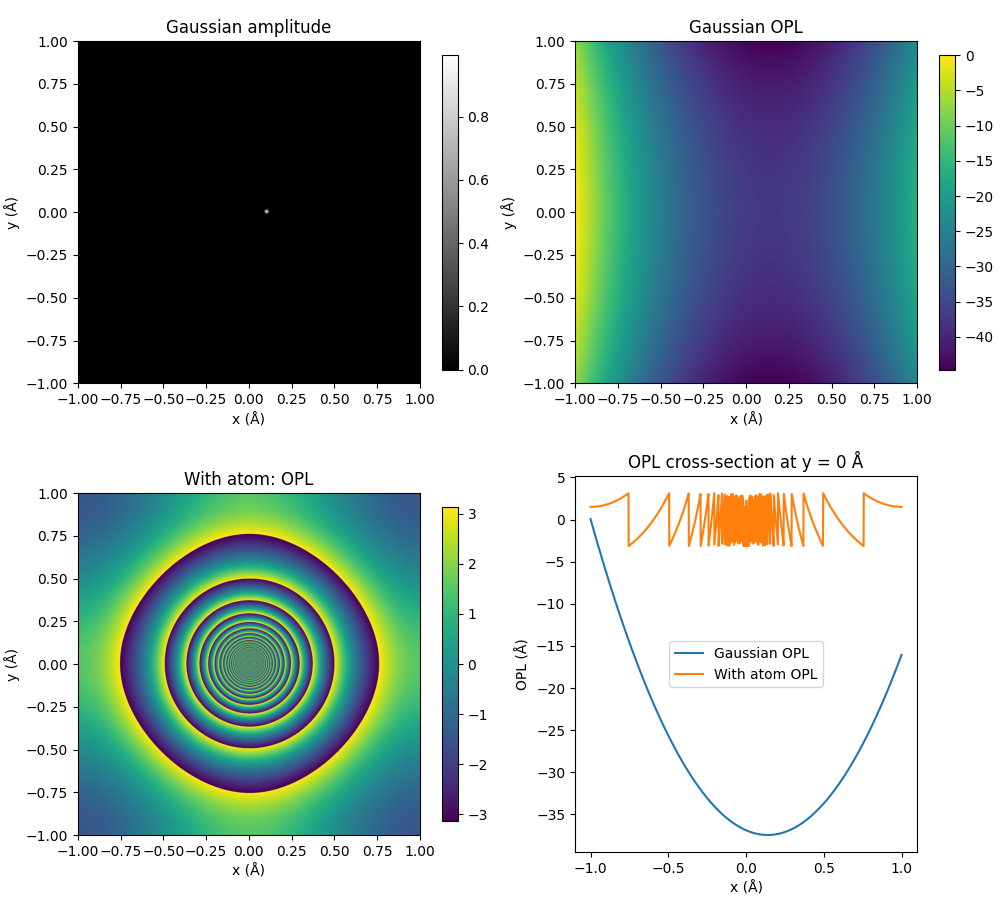

In [6]:
from skimage.restoration import unwrap_phase

# Visualize: amplitude and phase, plus 1D phase cross-section through y=0
extent = (-W/2, W/2, -W/2, W/2)

I_gauss = np.abs(E_gauss)
phi_gauss = np.angle(E_gauss)
I_sample = np.abs(E_sample)
phi_sample = np.angle(E_sample)

opl_gauss = unwrap_phase(phi_gauss)
opl_sample = unwrap_phase(phi_sample)

fig, axes = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)

ax = axes[0, 0]
im = ax.imshow(I_gauss, origin='lower', extent=extent, cmap='gray', aspect='equal')
ax.set_title('Gaussian amplitude')
ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

ax = axes[0, 1]
im = ax.imshow(opl_gauss, origin='lower', extent=extent, cmap='viridis', aspect='equal')
ax.set_title('Gaussian OPL')
ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

ax = axes[1, 0]
im = ax.imshow(phi_sample, origin='lower', extent=extent, cmap='viridis', aspect='equal')
ax.set_title('With atom: OPL')
ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

# 1D phase cross-section at y=0
y_vals = np.linspace(extent[2], extent[3], Ny)
y_idx = int(np.argmin(np.abs(y_vals - 0.0)))
x_vals = np.linspace(extent[0], extent[1], Nx)
ax = axes[1, 1]
ax.plot(x_vals, opl_gauss[y_idx, :], label='Gaussian OPL')
ax.plot(x_vals, phi_sample[y_idx, :], label='With atom OPL')
ax.set_title('OPL cross-section at y = 0 Å')
ax.set_xlabel('x (Å)')
ax.set_ylabel('OPL (Å)')
ax.legend()